In [2]:
%load_ext autoreload
%autoreload 2

%load_ext dotenv
%dotenv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
from pathlib import Path

import numpy as onp
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

import colorcet as cc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from dtd.data import load_wiltschko22_data
from dtd.viz import draw_drug_class_boxes, set_syllable_cluster_ticks, set_time_within_session_ticks

In [7]:
# OUTPUT_DIR = Path(os.environ['OUTPUT_DIR'])
OUTPUT_DIR = Path('/home/groups/swl1/eyz/dirichlet-tucker/analysis/moseq-drugs/crossval_prediction/results-diff-seeds')

## Target: 'drug'

In [8]:
target_name = 'drug'

results_files = [f for f in (OUTPUT_DIR/target_name).iterdir()]
print(f"total results: {len(results_files)}")
print(results_files)
# with onp.load(OUTPUT_DIR/target_name/f"{model_name}-48-*")

total results: 22
[PosixPath('/home/groups/swl1/eyz/dirichlet-tucker/analysis/moseq-drugs/crossval_prediction/results-diff-seeds/drug/lda-4-1740692990.npz'), PosixPath('/home/groups/swl1/eyz/dirichlet-tucker/analysis/moseq-drugs/crossval_prediction/results-diff-seeds/drug/lda-96-1740693717.npz'), PosixPath('/home/groups/swl1/eyz/dirichlet-tucker/analysis/moseq-drugs/crossval_prediction/results-diff-seeds/drug/lda-24-1740693204.npz'), PosixPath('/home/groups/swl1/eyz/dirichlet-tucker/analysis/moseq-drugs/crossval_prediction/results-diff-seeds/drug/lda-32-1740693305.npz'), PosixPath('/home/groups/swl1/eyz/dirichlet-tucker/analysis/moseq-drugs/crossval_prediction/results-diff-seeds/drug/lda-2-1740692952.npz'), PosixPath('/home/groups/swl1/eyz/dirichlet-tucker/analysis/moseq-drugs/crossval_prediction/results-diff-seeds/drug/dtd-256-13.npz'), PosixPath('/home/groups/swl1/eyz/dirichlet-tucker/analysis/moseq-drugs/crossval_prediction/results-diff-seeds/drug/dtd-64-1740685865.npz'), PosixPath(

In [9]:
# Get unique dims fitted for each model.
all_model_names = ['sum', 'lda', 'tca', 'dtd']
model_name_and_dims = {name: [] for name in all_model_names}
for f in results_files:
    model_name, model_dim, _ = str(f.stem).split('-')

    model_name_and_dims[model_name].append(int(model_dim))

for name, dims in model_name_and_dims.items():
    dims = list(set(dims))

print(model_name_and_dims)

{'sum': [90], 'lda': [4, 96, 24, 32, 2, 16, 128, 48, 8, 256, 64], 'tca': [], 'dtd': [256, 64, 16, 48, 8, 4, 32, 96, 24, 2]}


In [10]:
all_results = {model_name: {} for model_name in ['sum', 'lda', 'tca', 'dtd']}

i_file = 0

label_binarizer = None
label_encoder = None
for i_file, fpath in enumerate(results_files):
    with onp.load(fpath, allow_pickle=True) as f:
        assert target_name == f['target_name'], f"Expected results for {target_name}, but got {f['target_name']}"
        
        # Labels are shared for a given target type
        if i_file == 0:
            label_binarizer = LabelBinarizer().fit(f['label_classes'])
            label_binarizer.classes_ = f['label_classes']

            label_encoder = LabelEncoder().fit(f['label_classes'])
            label_encoder.classes_ = f['label_classes']

            n_labels = len(f['label_classes'])

        # Calculate metrics
        y_true, y_pred = f['all_y_true'], f['all_y_pred']  # shape (n_splits*n_test,)
        y_true_onehot = label_binarizer.transform(label_encoder.inverse_transform(y_true))  # shape (n_splits * n_test, n_labels)
        scores = f['all_scores']  # shape (n_splits*n_test, n_labels)
        
        cm = confusion_matrix(y_true, y_pred, normalize='all')  # shape (n_labels, n_labels)
        f1_by_class = f1_score(y_true, y_pred, average=None)    # shape (n_labels,)

        # Precision and recall
        # Per class
        precision_by_class, recall_by_class = dict(), dict()
        for i, lbl in enumerate(label_binarizer.classes_):
            precision_by_class[lbl], recall_by_class[lbl], _ = precision_recall_curve(
                y_true_onehot[:,i], scores[:,i]
            ) # shape (n_thresh,) where n_thresh = np.unique(scores)
        
        # "Micro-average" over all classes
        precision_all_classes, recall_all_classes, _ = precision_recall_curve(
            y_true_onehot.ravel(), scores.ravel()
        )  # shape (n_thresh,) where n_thresh = np.unique(scores)

        these_results = dict(
            cm=cm,
            f1_by_class=f1_by_class,
            precision_by_class=precision_by_class,
            recall_by_class=recall_by_class,
            precision_all_classes=precision_all_classes,
            recall_all_classes=recall_all_classes,
        )

        # Store in dict
        name = str(f['model_name'])
        dim = int(f['model_dim'])
        all_results[name][dim] = these_results  # for now, assume just a single fold


### Average F1 score vs. model dimensionality

sum
lda
tca results empty, skipping
dtd


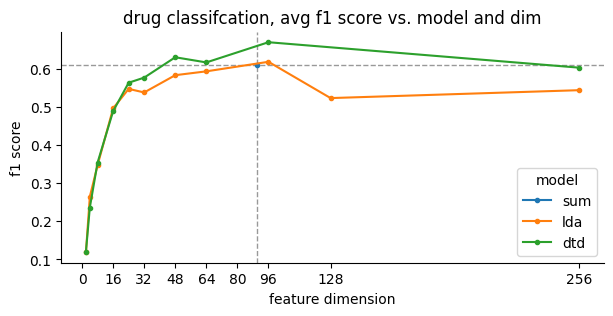

In [11]:
avg_f1_results = {}

plt.figure(figsize=(7,3))
ax = plt.gca()
for model_name, results_by_dim in all_results.items():
    
    # Ignore if empty
    if len(results_by_dim) == 0:
        print(f"{model_name} results empty, skipping")
        continue

    print(model_name)
    dims, avg_f1s = map(onp.asarray, map(list,
        zip(*[(dim, results['f1_by_class'].mean()) for dim, results in results_by_dim.items()])
    ))
    
    i_sort = onp.argsort(dims)
    dims = dims[i_sort]
    avg_f1s = avg_f1s[i_sort]

    avg_f1_results[model_name] = dict(dims=dims, avg_f1s=avg_f1s)

    ax.plot(
        dims, avg_f1s, label=model_name,
        marker='.',
    )

ax.set_xticks([0, 16, 32, 48, 64, 80, 96, 128, 256])
ax.legend(loc='lower right', title='model')

# add additional annoation for moseq
ax.axvline(avg_f1_results['sum']['dims'], ls='--', color='0.6', lw=1, zorder=0)
ax.axhline(avg_f1_results['sum']['avg_f1s'], ls='--', color='0.6', lw=1, zorder=0)

ax.set_xlabel('feature dimension')
ax.set_ylabel('f1 score')
ax.set_title(f'{target_name} classifcation, avg f1 score vs. model and dim')

sns.despine()

## Precision-recall

In [ ]:
# TODO
# precision recall by dimension
plt.figure(figsize=(7,3))
ax = plt.gca()
for model_name, results_by_dim in all_results.items():
    
    # Ignore if empty
    if len(results_by_dim) == 0:
        print(f"{model_name} results empty, skipping")
        continue

    print(model_name)
    dims, avg_f1s = map(onp.asarray, map(list,
        zip(*[(dim, results['f1_by_class'].mean()) for dim, results in results_by_dim.items()])
    ))
    
    i_sort = onp.argsort(dims)
    dims = dims[i_sort]
    avg_f1s = avg_f1s[i_sort]

    avg_f1_results[model_name] = dict(dims=dims, avg_f1s=avg_f1s)

    ax.plot(
        dims, avg_f1s, label=model_name,
        marker='.',
    )

ax.set_xticks([0, 16, 32, 48, 64, 80, 96, 128, 256])
ax.legend(loc='lower right', title='model')

# add additional annoation for moseq
ax.axvline(avg_f1_results['sum']['dims'], ls='--', color='0.6', lw=1, zorder=0)
ax.axhline(avg_f1_results['sum']['avg_f1s'], ls='--', color='0.6', lw=1, zorder=0)

ax.set_xlabel('feature dimension')
ax.set_ylabel('f1 score')
ax.set_title(f'{target_name} classifcation, avg f1 score vs. model and dim')

sns.despine()

## Target: Dose

In [23]:
target_name = 'class'

results_files = [f for f in (OUTPUT_DIR/target_name).iterdir()]
print(f"total results: {len(results_files)}")
print(results_files)
# with onp.load(OUTPUT_DIR/target_name/f"{model_name}-48-*")

total results: 10
[PosixPath('/home/groups/swl1/eyz/dirichlet-tucker/analysis/moseq-drugs/crossval_prediction/results/class/dtd-8-1740696048.npz'), PosixPath('/home/groups/swl1/eyz/dirichlet-tucker/analysis/moseq-drugs/crossval_prediction/results/class/dtd-32-1740696205.npz'), PosixPath('/home/groups/swl1/eyz/dirichlet-tucker/analysis/moseq-drugs/crossval_prediction/results/class/dtd-96-1740696432.npz'), PosixPath('/home/groups/swl1/eyz/dirichlet-tucker/analysis/moseq-drugs/crossval_prediction/results/class/dtd-64-1740696346.npz'), PosixPath('/home/groups/swl1/eyz/dirichlet-tucker/analysis/moseq-drugs/crossval_prediction/results/class/dtd-2-1740695972.npz'), PosixPath('/home/groups/swl1/eyz/dirichlet-tucker/analysis/moseq-drugs/crossval_prediction/results/class/dtd-16-1740696097.npz'), PosixPath('/home/groups/swl1/eyz/dirichlet-tucker/analysis/moseq-drugs/crossval_prediction/results/class/dtd-48-1740696264.npz'), PosixPath('/home/groups/swl1/eyz/dirichlet-tucker/analysis/moseq-drugs/cr

In [24]:
all_results = {model_name: {} for model_name in ['sum', 'lda', 'tca', 'dtd']}

i_file = 0

label_binarizer = None
label_encoder = None
for i_file, fpath in enumerate(results_files):
    with onp.load(fpath, allow_pickle=True) as f:
        assert target_name == f['target_name'], f"Expected results for {target_name}, but got {f['target_name']}"
        
        # Labels are shared for a given target type
        if i_file == 0:
            label_binarizer = LabelBinarizer().fit(f['label_classes'])
            label_binarizer.classes_ = f['label_classes']

            label_encoder = LabelEncoder().fit(f['label_classes'])
            label_encoder.classes_ = f['label_classes']

            n_labels = len(f['label_classes'])

        # Calculate metrics
        y_true, y_pred = f['all_y_true'], f['all_y_pred']  # shape (n_splits*n_test,)
        y_true_onehot = label_binarizer.transform(label_encoder.inverse_transform(y_true))  # shape (n_splits * n_test, n_labels)
        scores = f['all_scores']  # shape (n_splits*n_test, n_labels)
        
        cm = confusion_matrix(y_true, y_pred, normalize='all')  # shape (n_labels, n_labels)
        f1_by_class = f1_score(y_true, y_pred, average=None)    # shape (n_labels,)

        # Precision and recall
        # Per class
        precision_by_class, recall_by_class = dict(), dict()
        for i, lbl in enumerate(label_binarizer.classes_):
            precision_by_class[lbl], recall_by_class[lbl], _ = precision_recall_curve(
                y_true_onehot[:,i], scores[:,i]
            ) # shape (n_thresh,) where n_thresh = np.unique(scores)
        
        # "Micro-average" over all classes
        precision_all_classes, recall_all_classes, _ = precision_recall_curve(
            y_true_onehot.ravel(), scores.ravel()
        )  # shape (n_thresh,) where n_thresh = np.unique(scores)

        these_results = dict(
            cm=cm,
            f1_by_class=f1_by_class,
            precision_by_class=precision_by_class,
            recall_by_class=recall_by_class,
            precision_all_classes=precision_all_classes,
            recall_all_classes=recall_all_classes,
        )

        # Store in dict
        name = str(f['model_name'])
        dim = int(f['model_dim'])
        all_results[name][dim] = these_results  # for now, assume just a single fold


sum
lda results empty, skipping
tca results empty, skipping
dtd


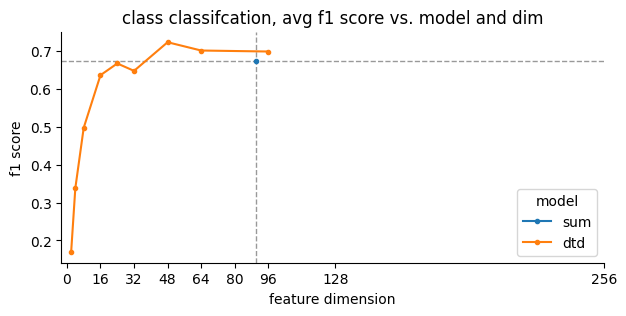

In [25]:
avg_f1_results = {}

plt.figure(figsize=(7,3))
ax = plt.gca()
for model_name, results_by_dim in all_results.items():
    
    # Ignore if empty
    if len(results_by_dim) == 0:
        print(f"{model_name} results empty, skipping")
        continue

    print(model_name)
    dims, avg_f1s = map(onp.asarray, map(list,
        zip(*[(dim, results['f1_by_class'].mean()) for dim, results in results_by_dim.items()])
    ))
    
    i_sort = onp.argsort(dims)
    dims = dims[i_sort]
    avg_f1s = avg_f1s[i_sort]

    avg_f1_results[model_name] = dict(dims=dims, avg_f1s=avg_f1s)

    ax.plot(
        dims, avg_f1s, label=model_name,
        marker='.',
    )

ax.set_xticks([0, 16, 32, 48, 64, 80, 96, 128, 256])
ax.legend(loc='lower right', title='model')

# add additional annoation for moseq
ax.axvline(avg_f1_results['sum']['dims'], ls='--', color='0.6', lw=1, zorder=0)
ax.axhline(avg_f1_results['sum']['avg_f1s'], ls='--', color='0.6', lw=1, zorder=0)

ax.set_xlabel('feature dimension')
ax.set_ylabel('f1 score')
ax.set_title(f'{target_name} classifcation, avg f1 score vs. model and dim')

sns.despine()